In [28]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import os, glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K



from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.utils import to_categorical

## Import Data

In [3]:
obj = pd.read_pickle(r'moonGen_scrape_2016_final')

In [4]:
len(obj)

30642

In [5]:
#HD is for Hold Difficulty. Each Hold has a Left hand and right hand difficulty. AvgDiff is the Avg between the two hands
HD = pd.read_csv('HoldDiff.csv')
HD['AvgDiff'] = (HD['LH_Diff']+HD['RH_Diff'])/2
HD['Inverted'] = (((10-HD['LH_Diff'])+(10-HD['RH_Diff']))/2)+1
HD.to_csv('hd.csv')

In [6]:
obj

{'367894': {'url': 'https://moonboard.com/Problems/View/367894/tall-poppy',
  'start': [[5, 4], [6, 1]],
  'mid': [[7, 9], [1, 10], [4, 14], [4, 7]],
  'end': [[3, 17]],
  'grade': '6C+',
  'user_grade': None,
  'is_benchmark': False,
  'repeats': 0,
  'problem_type': None,
  'is_master': False,
  'setter': {'Id': '93A38FE2-1B2B-4B0F-9B70-9A77BAE976B8',
   'Nickname': 'halladay',
   'Firstname': 'Jason',
   'Lastname': 'Halladay',
   'City': 'Los Alamos',
   'Country': 'United States',
   'ProfileImageUrl': '/Content/Account/Users/Profile/93A38FE2-1B2B-4B0F-9B70-9A77BAE976B8.gif?637231996892206329',
   'CanShareData': True}},
 '367892': {'url': 'https://moonboard.com/Problems/View/367892/cats-are-furry-children',
  'start': [[0, 4], [3, 5]],
  'mid': [[4, 8], [0, 8], [2, 12], [3, 14]],
  'end': [[0, 17]],
  'grade': '6C',
  'user_grade': None,
  'is_benchmark': False,
  'repeats': 1,
  'problem_type': None,
  'is_master': False,
  'setter': {'Id': '711F5068-4D73-451C-B228-8113EDFFC8DA'

In [57]:
#Grade distribution
grade_cnt = {}
for climbn in list(obj.keys()):
    grade = obj[climbn]['grade']
    grade_cnt[grade] = grade_cnt.get(grade,0) + 1
    
grade_cnt

{'6C+': 4617,
 '6C': 3836,
 '7A': 4045,
 '6B+': 10153,
 '7A+': 3074,
 '7C': 1061,
 '7B': 1551,
 '7B+': 1622,
 '8A': 181,
 '7C+': 389,
 '8B+': 24,
 '8A+': 51,
 '8B': 29,
 '6B': 9}

In [58]:
grade_cnt = dict(sorted(grade_cnt.items()))

<BarContainer object of 14 artists>

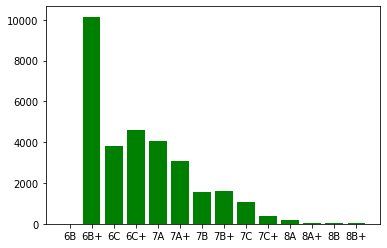

In [59]:
plt.bar(grade_cnt.keys(), grade_cnt.values(), color='g')

In [68]:
grade_split ={
    '6B':'6B',
    '6B+':'6B',
    '6C':'6C',
    '6C+':'6C',
    '7A':'7A',
    '7A+':'7A',
    '7B':'7B',
    '7B+':'7B',
    '7C':'7C',
    '7C+':'7C',
    '8A':'8+',
    '8A+':'8+',
    '8B':'8+',
    '8B+':'8+'
}

In [103]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

In [288]:
#Create Images from obj and save them in folders named after its grade category

grade_split ={
    '6B':'6B',
    '6B+':'6B',
    '6C':'6C',
    '6C+':'6C',
    '7A':'7A',
    '7A+':'7A',
    '7B':'7B',
    '7B+':'7B',
    '7C':'7C',
    '7C+':'7C',
    '8A':'8+',
    '8A+':'8+',
    '8B':'8+',
    '8B+':'8+'
}

plt.ioff()
for i in range(0, len(list(obj.keys())), 1000):
    x = i
    print(f'Iteration num: {i}')
    for climbn in list(obj.keys())[x:x+1000]:

        start = obj[climbn]['start']
        mid = obj[climbn]['mid']
        end = obj[climbn]['end']
        grade = obj[climbn]['grade']

        start_xs=list(zip(*start))[0]
        start_ys=list(zip(*start))[1]
        mid_xs=list(zip(*mid))[0]
        mid_ys=list(zip(*mid))[1]
        end_xs=list(zip(*end))[0]
        end_ys=list(zip(*end))[1]

        start_diff = []
        try:
            for h in start:
                start_diff.append(HD.loc[(HD['X_coord']==h[0]) & (HD['Y_coord']==h[1]),'AvgDiff'].values[0])
            mid_diff = []
            for h in mid:
                mid_diff.append(HD.loc[(HD['X_coord']==h[0]) & (HD['Y_coord']==h[1]),'AvgDiff'].values[0])
            end_diff = []
            for h in end:
                end_diff.append(HD.loc[(HD['X_coord']==h[0]) & (HD['Y_coord']==h[1]),'AvgDiff'].values[0])    
        except:
            print(obj[climbn])
            next


        allh=start+mid+end
        
        start_diff_color = ['green' if d<=3 else 'blue' if d<=7.5 else 'red' for d in start_diff]
        mid_diff_color = ['green' if d<=3 else 'blue' if d<=7.5 else 'red' for d in mid_diff]
        end_diff_color = ['green' if d<=3 else 'blue' if d<=7.5 else 'red' for d in end_diff]


        plt.figure(figsize=(10,10))
        plt.xlim([-2,12])
        plt.ylim([-2,19])
        plt.axis('off')


        for i, n in enumerate(allh):
            node = n
            nodes = allh.copy()
            nodes.remove(n)
            try:
                closest = closest_node(node,nodes)
                distance = np.linalg.norm(np.asarray(n) - np.asarray(nodes[closest]))
                if distance <= 3:
                    color='g'
                elif distance >= 5:
                    color='r'
                    plt.plot([n[0],nodes[closest][0]],[n[1],nodes[closest][1]], color=color, linewidth=5)
                else:
                    color='b'
            except:
                pass

        try:
            plt.scatter(start_xs,start_ys,color=start_diff_color,marker=',',s=500)
            plt.scatter(mid_xs,mid_ys,color=mid_diff_color,marker=',',s=500)
            plt.scatter(end_xs,end_ys,color=end_diff_color,marker=',',s=500)

            plt.savefig(f'all_data_6_classes_holdcolor/{grade_split[grade]}/{climbn}.png',dpi=50)
        except:
            print(obj[climbn])
            next

        plt.close('all')

Iteration num: 21000
{'url': 'https://moonboard.com/Problems/View/304387/blade-runner', 'start': [[5, 4], [1, 2], [0, 5]], 'mid': [[2, 8], [3, 12], [7, 13], [6, 16], [6, 10], [6, 10], [9, 10], [5, 7], [4, 12], [2, 15]], 'end': [[10, 17], [1, 17]], 'grade': '6B+', 'user_grade': '6B+', 'is_benchmark': False, 'repeats': 13, 'problem_type': None, 'is_master': False, 'setter': {'Id': 'E154E732-CCB3-465E-B189-7C12F021A609', 'Nickname': 'Enea Bionda', 'Firstname': 'Enea', 'Lastname': 'Bionda', 'City': 'Monte carasso', 'Country': 'SWITZERLAND', 'ProfileImageUrl': '/Content/Account/Images/default-profile.png?637231600167385149', 'CanShareData': True}}
{'url': 'https://moonboard.com/Problems/View/304387/blade-runner', 'start': [[5, 4], [1, 2], [0, 5]], 'mid': [[2, 8], [3, 12], [7, 13], [6, 16], [6, 10], [6, 10], [9, 10], [5, 7], [4, 12], [2, 15]], 'end': [[10, 17], [1, 17]], 'grade': '6B+', 'user_grade': '6B+', 'is_benchmark': False, 'repeats': 13, 'problem_type': None, 'is_master': False, 'sett

## Helper Functions

In [14]:
def plot_history(history_all, model_name):
    """
    Plot the training history of the model
    """
    # Plot training & validation accuracy values
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    for history in history_all:
        if 'sparse_categorical_accuracy' in history.history.keys():
            acc.append(history.history['sparse_categorical_accuracy'])
            val_acc.append(history.history['val_sparse_categorical_accuracy'])
            loss.append(history.history['loss'])
            val_loss.append(history.history['val_loss']) 
        elif 'f1' in history.history.keys():
            acc.append(history.history['f1'])
            val_acc.append(history.history['val_f1'])
            loss.append(history.history['loss'])
            val_loss.append(history.history['val_loss'])
        else:
            acc.append(history.history['accuracy'])
            val_acc.append(history.history['val_accuracy'])
            loss.append(history.history['loss'])
            val_loss.append(history.history['val_loss'])

    acc = sum(acc, [])
    val_acc = sum(val_acc, [])
    loss = sum(loss, [])
    val_loss = sum(val_loss, [])

    fig, axes = plt.subplots(nrows = 1, ncols = 2, dpi = 150)
    axes[0].plot(acc)
    axes[0].plot(val_acc)
    axes[0].set_title('Accuracy of '+ model_name)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Val'], loc='upper left')

    axes[1].plot(loss)
    axes[1].plot(val_loss)
    axes[1].set_title('Loss of ' + model_name)
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Val'], loc='upper left')
    plt.tight_layout()
    
    history_package = {'acc': acc, 
                       'val_acc': val_acc, 
                       'loss': loss, 
                       'val_loss': val_loss}
    return history_package

In [26]:
def CMPlot(y_actual, y_predicted, class_names):
    """
    Plot cleaner looking Confusion Matrix
    """
    fig, ax = plt.subplots(figsize=(6,6))
    tick_marks = np.arange(len(class_names))
    sns.heatmap(pd.DataFrame(confusion_matrix(y_actual,y_predicted)), annot=True, cmap="YlGnBu" ,fmt='g')
    #ax.xaxis.set_label_position("middle")
    plt.xticks(tick_marks+0.5, labels=class_names, rotation='vertical')
    plt.yticks(tick_marks+0.5, labels=class_names, rotation='horizontal')
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show

In [ ]:
def f1(y_true, y_pred):
    """
    F1 function for use as model compiling metrics
    """
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## CNN Model 1

In [31]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
        'all_data_6_classes_holdcolor/',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        'all_data_6_classes_holdcolor/',
        target_size=(64, 64),
        batch_size=32,
        shuffle = False,
        class_mode='categorical',
        subset='validation')

Found 27579 images belonging to 6 classes.
Found 3062 images belonging to 6 classes.


In [32]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size = 3, input_shape=(64,64,3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size = 3, activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(128,activation='relu'))
model1.add(tf.keras.layers.Dense(6,activation='softmax')) #Final Dense layer units has to be # of categories
model1.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [33]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [34]:
class_cnts = np.unique(train_generator.labels, return_counts=True)[1]+np.unique(validation_generator.labels, return_counts=True)[1]
class_cnts

array([10161,  8453,  7119,  3173,  1450,   285], dtype=int64)

In [35]:
max(class_cnts)/class_cnts

array([ 1.        ,  1.20205844,  1.42730721,  3.20233218,  7.00758621,
       35.65263158])

In [36]:
color_history_all = []

In [37]:
for i in range(5):
    color_history = model1.fit_generator(train_generator,validation_data=validation_generator,epochs=5,class_weight={0:1,1:1.202,2:1.427,3:3.202,4:7.008,5:35.656})
    color_history_all.append(color_history)

C:\Users\davi_\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
862/862 [==============================] - 268s 309ms/step - loss: 2.8954 - accuracy: 0.4084 - val_loss: 1.1875 - val_accuracy: 0.4784
Epoch 2/5
862/862 [==============================] - 259s 301ms/step - loss: 2.5134 - accuracy: 0.4677 - val_loss: 1.1764 - val_accuracy: 0.4637
Epoch 3/5
862/862 [==============================] - 262s 304ms/step - loss: 2.3637 - accuracy: 0.4920 - val_loss: 1.1007 - val_accuracy: 0.5033
Epoch 4/5
862/862 [==============================] - 260s 302ms/step - loss: 2.2036 - accuracy: 0.5134 - val_loss: 1.0928 - val_accuracy: 0.5007
Epoch 5/5
862/862 [==============================] - 262s 304ms/step - loss: 2.0231 - accuracy: 0.5253 - val_loss: 1.2109 - val_accuracy: 0.4543
Epoch 1/5
862/862 [==============================] - 264s 306ms/step - loss: 1.9016 - accuracy: 0.5420 - val_loss: 1.1777 - val_accuracy: 0.4905
Epoch 2/5
862/862 [==============================] - 262s 304ms/step - loss: 1.7669 - accuracy: 0.5536 - val_loss: 1.1900 - val_ac

In [39]:
predictions = model1.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())   
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

96/96 [==============================] - 15s 154ms/step
              precision    recall  f1-score   support

          6B       0.67      0.71      0.69      1016
          6C       0.45      0.44      0.44       845
          7A       0.43      0.36      0.39       711
          7B       0.28      0.35      0.31       317
          7C       0.33      0.32      0.33       145
          8+       0.16      0.14      0.15        28

    accuracy                           0.49      3062
   macro avg       0.39      0.39      0.39      3062
weighted avg       0.49      0.49      0.49      3062



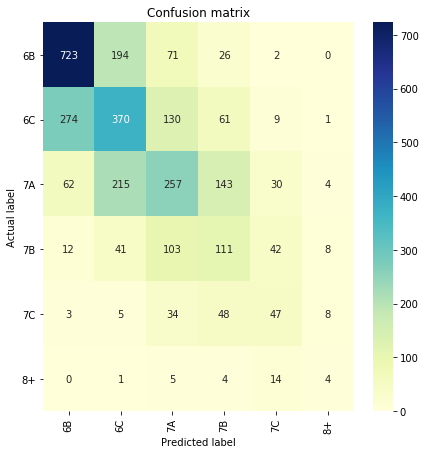

In [41]:
CMPlot(validation_generator.classes, predicted_classes,class_labels)

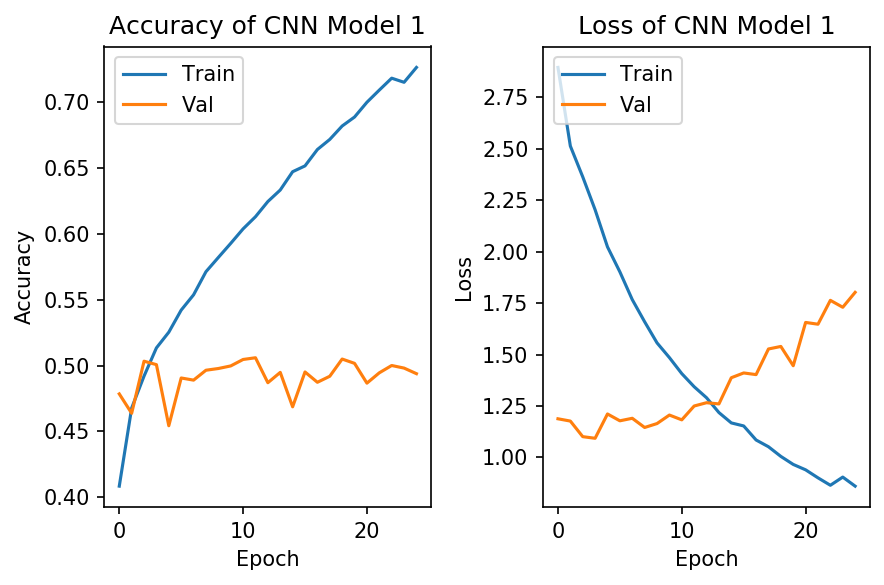

In [40]:
color_history_package = plot_history(color_history_all, 'CNN Model 1')

## CNN Model 2

In [21]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
        'all_data_6_classes_holdcolor/',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        'all_data_6_classes_holdcolor/',
        target_size=(64, 64),
        batch_size=32,
        shuffle = False,
        class_mode='categorical',
        subset='validation')

Found 27579 images belonging to 6 classes.
Found 3062 images belonging to 6 classes.


In [22]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv2D(filters=32, kernel_size = 3, input_shape=(64,64,3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Conv2D(filters=64, kernel_size = 3, activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Conv2D(filters=128, kernel_size = 3, activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Conv2D(filters=256, kernel_size = 3, activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(6,activation='softmax')) #Final Dense layer units has to be # of categories
model2.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [80]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 6, 6, 128)       

In [23]:
model2.fit_generator(train_generator,validation_data=validation_generator,epochs=20,class_weight={0:1,1:1.202,2:1.427,3:3.202,4:7.008,5:35.656})

C:\Users\davi_\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/20
862/862 [==============================] - 319s 368ms/step - loss: 3.5214 - accuracy: 0.1682 - val_loss: 1.5285 - val_accuracy: 0.3223
Epoch 2/20
862/862 [==============================] - 328s 380ms/step - loss: 2.8870 - accuracy: 0.3830 - val_loss: 1.1465 - val_accuracy: 0.4804
Epoch 3/20
862/862 [==============================] - 362s 419ms/step - loss: 2.5901 - accuracy: 0.4498 - val_loss: 1.2622 - val_accuracy: 0.4370
Epoch 4/20
862/862 [==============================] - 333s 386ms/step - loss: 2.4261 - accuracy: 0.4701 - val_loss: 1.1946 - val_accuracy: 0.4566
Epoch 5/20
862/862 [==============================] - 328s 380ms/step - loss: 2.3133 - accuracy: 0.4903 - val_loss: 1.1223 - val_accuracy: 0.4863
Epoch 6/20
862/862 [==============================] - 326s 378ms/step - loss: 2.2114 - accuracy: 0.4995 - val_loss: 1.0783 - val_accuracy: 0.5029
Epoch 7/20
862/862 [==============================] - 327s 380ms/step - loss: 2.1168 - accuracy: 0.5083 - val_loss: 1.1408 -

In [24]:
predictions = model2.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())   
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

96/96 [==============================] - 17s 168ms/step
              precision    recall  f1-score   support

          6B       0.74      0.70      0.72      1016
          6C       0.48      0.44      0.46       845
          7A       0.46      0.50      0.48       711
          7B       0.33      0.35      0.34       317
          7C       0.34      0.43      0.38       145
          8+       0.22      0.14      0.17        28

    accuracy                           0.53      3062
   macro avg       0.43      0.43      0.42      3062
weighted avg       0.54      0.53      0.53      3062



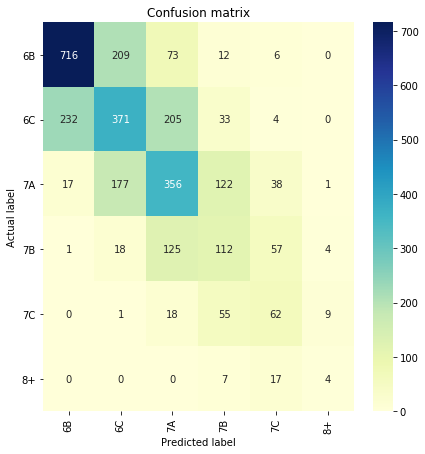

In [29]:
CMPlot(validation_generator.classes, predicted_classes,class_labels)

In [270]:
history_all = []

In [271]:
for i in range(5):
    history = model2.fit_generator(train_generator,validation_data=validation_generator,epochs=20,class_weight={0:1,1:1.202,2:1.427,3:3.202,4:7.008,5:35.656})
    model.save('cnn_6cat_model.h5')
    history_all.append(history)

C:\Users\davi_\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
862/862 [==============================] - 327s 377ms/step - loss: 3.3725 - accuracy: 0.2727 - val_loss: 1.4291 - val_accuracy: 0.3563
Epoch 2/20
862/862 [==============================] - 315s 365ms/step - loss: 3.1122 - accuracy: 0.3515 - val_loss: 1.4372 - val_accuracy: 0.3893
Epoch 3/20
862/862 [==============================] - 330s 382ms/step - loss: 2.8610 - accuracy: 0.3900 - val_loss: 1.2103 - val_accuracy: 0.4389
Epoch 4/20
862/862 [==============================] - 329s 381ms/step - loss: 2.6663 - accuracy: 0.4281 - val_loss: 1.2039 - val_accuracy: 0.4637
Epoch 5/20
862/862 [==============================] - 329s 381ms/step - loss: 2.5523 - accuracy: 0.4426 - val_loss: 1.3884 - val_accuracy: 0.3955
Epoch 6/20
862/862 [==============================] - 327s 379ms/step - loss: 2.4293 - accuracy: 0.4559 - val_loss: 1.2172 - val_accuracy: 0.4572
Epoch 7/20
862/862 [==============================] - 329s 381ms/step - loss: 2.2970 - accuracy: 0.4702 - val_loss: 1.1335 -

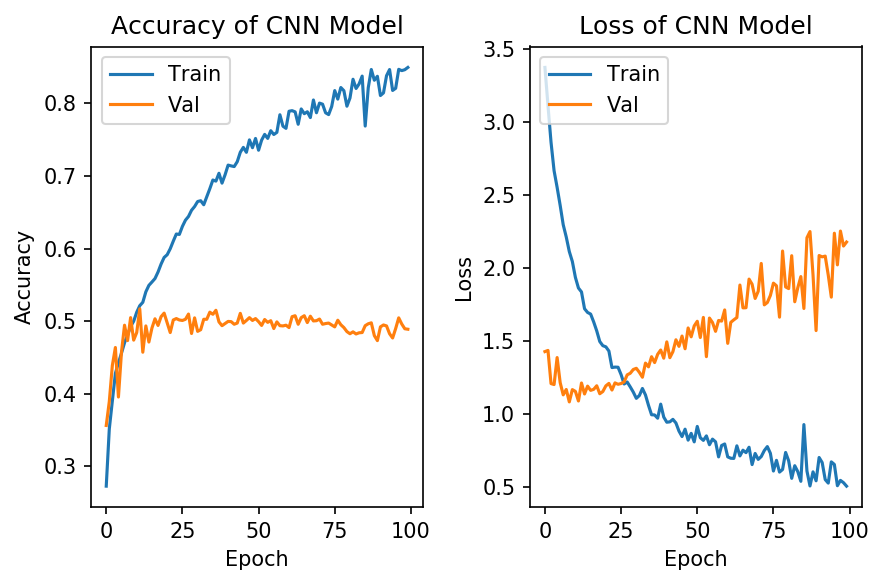

In [272]:
history_package = plot_history(history_all, 'CNN Model')

## Regularized Model 2 

In [72]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv2D(filters=32, kernel_size = 3, input_shape=(64,64,3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Conv2D(filters=64, kernel_size = 3, activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Conv2D(filters=128, kernel_size = 3, activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Conv2D(filters=256, kernel_size = 3, activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(6,activation='softmax')) #Final Dense layer units has to be # of categories
model2.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [73]:
model2.fit_generator(train_generator,validation_data=validation_generator,epochs=12,class_weight={0:1,1:1.202,2:1.427,3:3.202,4:7.008,5:35.656})

C:\Users\davi_\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/12
862/862 [==============================] - 321s 370ms/step - loss: 3.5431 - accuracy: 0.1276 - val_loss: 1.7944 - val_accuracy: 0.0343
Epoch 2/12
862/862 [==============================] - 332s 385ms/step - loss: 3.0027 - accuracy: 0.3586 - val_loss: 1.2166 - val_accuracy: 0.4549
Epoch 3/12
862/862 [==============================] - 337s 391ms/step - loss: 2.6586 - accuracy: 0.4375 - val_loss: 1.2493 - val_accuracy: 0.4481
Epoch 4/12
862/862 [==============================] - 354s 410ms/step - loss: 2.4967 - accuracy: 0.4600 - val_loss: 1.1635 - val_accuracy: 0.4758
Epoch 5/12
862/862 [==============================] - 355s 411ms/step - loss: 2.3689 - accuracy: 0.4816 - val_loss: 1.1001 - val_accuracy: 0.5046
Epoch 6/12
862/862 [==============================] - 350s 406ms/step - loss: 2.2627 - accuracy: 0.4885 - val_loss: 1.0710 - val_accuracy: 0.5105
Epoch 7/12
862/862 [==============================] - 399s 463ms/step - loss: 2.1686 - accuracy: 0.4996 - val_loss: 1.0349 -

In [78]:
predictions = model2.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())   
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

96/96 [==============================] - 21s 214ms/step
              precision    recall  f1-score   support

          6B       0.81      0.59      0.68      1016
          6C       0.47      0.55      0.51       845
          7A       0.47      0.52      0.49       711
          7B       0.35      0.38      0.36       317
          7C       0.39      0.40      0.40       145
          8+       0.20      0.43      0.27        28

    accuracy                           0.53      3062
   macro avg       0.45      0.48      0.45      3062
weighted avg       0.56      0.53      0.54      3062



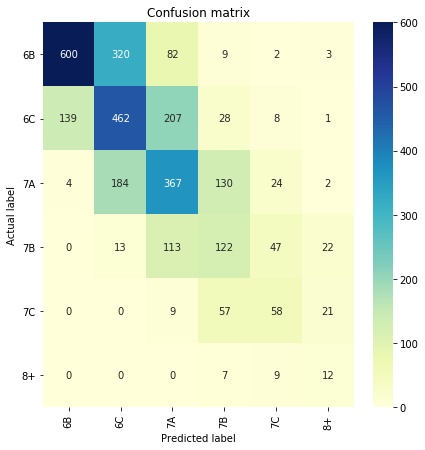

In [79]:
CMPlot(validation_generator.classes, predicted_classes,class_labels)

## Output Predictions as CSV for Future Use in DNN Model

In [74]:
all_datagen = ImageDataGenerator(
        rescale=1./255)

all_generator = all_datagen.flow_from_directory(
        'all_data_6_classes_holdcolor/',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

all_predictions = model2.predict(all_generator)
all_predicted_classes = np.argmax(all_predictions, axis=1)
all_true_classes = all_generator.classes
all_class_labels = list(all_generator.class_indices.keys())   
report = classification_report(all_true_classes, all_predicted_classes, target_names=all_class_labels)
print(report)

Found 30641 images belonging to 6 classes.
958/958 [==============================] - 207s 216ms/step
              precision    recall  f1-score   support

          6B       0.84      0.60      0.70     10161
          6C       0.51      0.59      0.55      8453
          7A       0.52      0.58      0.55      7119
          7B       0.49      0.53      0.51      3173
          7C       0.59      0.68      0.63      1450
          8+       0.41      0.94      0.57       285

    accuracy                           0.59     30641
   macro avg       0.56      0.65      0.58     30641
weighted avg       0.62      0.59      0.60     30641



In [77]:
img_classes = pd.DataFrame({'image_name':all_generator.filenames, 'cnn_pred_class':all_predicted_classes})

img_classes['img_name'] = img_classes['image_name'].str[3:9]
img_classes['actual'] = img_classes['image_name'].str[:2]
img_classes['cnn_pred_conv'] = img_classes['cnn_pred_class'].map(dict((v, k) for k, v in all_generator.class_indices.items()))
img_classes.drop('image_name', axis=1,inplace=True)
img_classes.to_csv('cnn_pred.csv')